# Mount and Load

In [3]:
import pandas as pd


def load(path):
    return pd.read_csv(path)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# load data
train_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/userTrainData.csv")
test_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/userTestData.csv")
all_df = pd.concat([train_df,test_df])

# Data Exploration

In [7]:
features = train_df.shape[1]
samples = train_df.shape[0]

print(f'The data contains {features} features and {samples} samples')
print(f'Feature names: {train_df.columns.values}')

The data contains 5 features and 2303580 samples
Feature names: ['Unnamed: 0' 'user_id' 'business_id' 'stars' 'text']


Ratings amount:


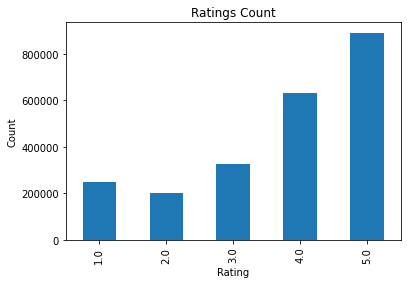

In [8]:
# Ratings
print("Ratings amount:")
train_df["stars"].value_counts().sort_index().plot.bar(title="Ratings Count", xlabel="Rating", ylabel="Count")

In [9]:
# Users
amount_users = train_df["user_id"].nunique()
avg_ratings_per_user = samples / amount_users
print(f'Amount of unique users: {amount_users}')
print(f'Average amount of ratings per user: {avg_ratings_per_user}')

Amount of unique users: 239007
Average amount of ratings per user: 9.63812775358044


In [10]:
# Businesses

amount_businesses = train_df["business_id"].nunique()
print(f'Amount of unique businesses: {amount_businesses}')

Amount of unique businesses: 159168


#Collaborative Filtering

## Model Building

###SVD

In [ ]:
# Model class
import time
import math
import numpy as np


class RecommenderSystemSVD:
  def __init__(self, lr=.005, reg=.02, n_epochs=100, n_factors=70):

    self.lr = lr
    self.reg = reg
    self.n_epochs = n_epochs
    self.n_factors = n_factors
  
  def init_metrics(self):
    """
    initializes the RMSE, loss and MAE metrics dataframe for each epoch
    """
    metrics = np.zeros((self.n_epochs, 3), dtype=np.float)
    self.metrics = pd.DataFrame(metrics, columns=['Loss', 'RMSE', 'MAE'])
  
  def preprocess_data(self, X, is_training = True):
    """
    preparing the data and transforms categorical values into integers
    """

    print('Preprocessing data...\n')

    if is_training:
      user_ids = X['user_id'].unique().tolist()
      item_ids = X['business_id'].unique().tolist()
      n_users = len(user_ids)
      n_items = len(item_ids)
      user_idx = range(n_users)
      item_idx = range(n_items)
      self.user_mapping_ = dict(zip(user_ids, user_idx))
      self.item_mapping_ = dict(zip(item_ids, item_idx))

    X['user_id'] = X['user_id'].map(self.user_mapping_)
    X['business_id'] = X['business_id'].map(self.item_mapping_)
    # Tag validation set unknown users/items with -1 (enables
    # us to detect them when calculating the metrics)
    X.fillna(-1, inplace=True)
    X['user_id'] = X['user_id'].astype(np.int32)
    X['business_id'] = X['business_id'].astype(np.int32)
    return X[['user_id', 'business_id', 'stars']].values

  def TrainBaseModel(self, train_df):
    # split train and validation - 80% train
    train = train_df.sample(frac=0.8, random_state=7)
    val = train_df.drop(train.index.tolist())

    X = self.preprocess_data(train)
    X_val = self.preprocess_data(val, is_training = False) # we do not train the model's indices on the validation data
    self.init_metrics()
    self.global_mue = np.mean(X[:, 2])
    self.run_sgd(X, X_val)

  def run_sgd(self, X, X_val):
    n_users = len(np.unique(X[:,0]))
    n_items = len(np.unique(X[:,1]))
    
    # initialize parameters
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    pu = np.random.normal(0, .1, (n_users, self.n_factors))
    qi = np.random.normal(0, .1, (n_items, self.n_factors))

    # run the SGD (Stochastic Gradient Descent) algorithm
    for epoch_i in range (self.n_epochs):
      print(f"Epoch {epoch_i} starts running")
      start_time = time.time()
      bu, bi, pu, qi = self.run_epoch(X, bu, bi, pu, qi, self.global_mue,
                                      self.n_factors, self.lr, self.reg)
      
      # metrics computing
      self.metrics.loc[epoch_i, :] = self.compute_metrics(X_val, bu, bi, pu, qi, self.global_mue, self.n_factors)

      end_time = time.time()
      
      print(f"Epoch {epoch_i} ran: {round(end_time - start_time, 2)} seconds, validation set metrics: Loss: {self.metrics.loc[epoch_i, 'Loss']}, RMSE: {self.metrics.loc[epoch_i, 'RMSE']}, MAE: {self.metrics.loc[epoch_i, 'MAE']}")
      if epoch_i > 0:
        rmse_improvement = self.metrics.loc[epoch_i, 'RMSE'] - self.metrics.loc[epoch_i - 1, 'RMSE']
        print(f"RMSE improvement from last epoch: {rmse_improvement}")
        # early stopping
        if rmse_improvement > 0:
          # the last training step raised the RMSE - early stopping criterion
          print("Early stopping criterion reached")
          break
      
      self.bu_ = bu
      self.bi_ = bi
      self.pu_ = pu
      self.qi_ = qi

  def compute_metrics(self, X_val, bu, bi, pu, qi, global_mue, n_factors):
    """
    computes mse, rmse and mae measures
    """
    residuals = []
    for i in range(X_val.shape[0]):
        user, item, rating = int(X_val[i, 0]), int(X_val[i, 1]), X_val[i, 2]
        pred = global_mue
        if user > -1:
            pred += bu[user]
        if item > -1:
            pred += bi[item]
        if (user > -1) and (item > -1):
          pred += np.transpose(qi[item, :]).dot(pu[user,:])

        residuals.append(rating - pred)
    residuals = np.array(residuals)
    loss = np.square(residuals).mean()
    rmse = np.sqrt(loss)
    mae = np.absolute(residuals).mean()
    return loss, rmse, mae

  def predict_rating(self, X_test):
    bu = self.bu_
    bi = self.bi_
    pu = self.pu_
    qi = self.qi_
    test = self.preprocess_data(X_test, is_training = False)
    pred_vec = []
    for i in range(test.shape[0]):
      user, item, rating = int(test[i, 0]), int(test[i, 1]), test[i, 2]
      pred = self.global_mue
      if user > -1:
          pred += bu[user]
      if item > -1:
          pred += bi[item]
      if (user > -1) and (item > -1):
        pred += np.transpose(qi[item, :]).dot(pu[user,:])
      pred_vec.append(pred)
    
    return pred_vec


  def run_epoch(self, X, bu, bi, pu, qi, global_mean, n_factors, lr, reg):
    for i in range(X.shape[0]):
      user, item, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]
      # calculate r_hat
      pred = global_mean + bu[user] + bi[item]
      # add the factors calculation to r_hat
      pred += np.transpose(qi[item, :]).dot(pu[user, :])

      # calculate the error of r_hat and the real r
      err = rating - pred
      # update all parameters
      # update biases
      bu[user] += lr * (err - reg * bu[user])
      bi[item] += lr * (err - reg * bi[item])
      # update the latent factors
      pu_user = pu[user,:]
      qi_item = qi[item, :]
      
      pu[user, :] += lr * (err * qi_item - reg * pu_user)
      qi[item, :] += lr * (err * pu_user - reg * qi_item)

    return bu, bi, pu, qi

###SVD++

In [ ]:
# Model class
import time
import math


class RecommenderSystemSVDpp:
  def __init__(self, lr=.005, reg=.02, n_epochs=100, n_factors=70, lamda5 = 0.005, lamda6 = 0.015, gamma = 0.007):
    self.n_epochs = n_epochs
    self.n_factors = n_factors
    # svdpp parameters
    self.lamda5 = lamda5
    self.lamda6 = lamda6
    self.gamma = gamma
  
  def init_metrics(self):
    """
    initializes the RMSE, loss and MAE metrics dataframe for each epoch
    """
    metrics = np.zeros((self.n_epochs, 3), dtype=np.float)
    self.metrics = pd.DataFrame(metrics, columns=['Loss', 'RMSE', 'MAE'])

  def get_user_items(self, X):
    df = pd.DataFrame(columns = ['user_id', 'ranked_items'])
    user_items_dict = {}
    for _, row in X.iterrows():
      user = row['user_id']
      business_id = row['business_id']
      if user in user_items_dict:
        user_items = user_items_dict[user]
        if business_id not in user_items:
          user_items_dict[user].append(business_id)
      else:
        user_items_dict[user] = [business_id]
    return user_items_dict
      


  def preprocess_data(self, X, is_training = True):
    print('Preprocessing data...\n')

    if is_training:
      user_ids = X['user_id'].unique().tolist()
      item_ids = X['business_id'].unique().tolist()
      n_users = len(user_ids)
      n_items = len(item_ids)
      user_idx = range(n_users)
      item_idx = range(n_items)
      self.user_mapping_ = dict(zip(user_ids, user_idx))
      self.item_mapping_ = dict(zip(item_ids, item_idx))

    X['user_id'] = X['user_id'].map(self.user_mapping_)
    X['business_id'] = X['business_id'].map(self.item_mapping_)
    # Tag validation set unknown users/items with -1 (enables
    # us to detect them when calculating the metrics)
    X.fillna(-1, inplace=True)
    X['user_id'] = X['user_id'].astype(np.int32)
    X['business_id'] = X['business_id'].astype(np.int32)

    if is_training:
      # only if the data is a training data - get all items a user ranked
      self.user_items_dict = self.get_user_items(X)

    return X[['user_id', 'business_id', 'stars']].values

  def TrainSVDppModel(self, train_df):
    train = train_df.sample(frac=0.8, random_state=7)
    val = train_df.drop(train.index.tolist())
    X = self.preprocess_data(train)
    X_val = self.preprocess_data(val, is_training = False) # we do not train the model's indices on the validation data
    self.init_metrics()
    self.global_mue = np.mean(X[:, 2])
    self.run_sgd_svdpp(X, X_val)
  
  def run_sgd_svdpp(self, X, X_val):
    n_users = len(np.unique(X[:,0]))
    n_items = len(np.unique(X[:,1]))
    # initialize parameters
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    pu = np.random.normal(0, .1, (n_users, self.n_factors))
    qi = np.random.normal(0, .1, (n_items, self.n_factors))
    yj = np.random.normal(0, .1, (n_items, self.n_factors))


    # run the SGD (Stochastic Gradient Descent) algorithm for SVD++ algorithm
    for epoch_i in range (self.n_epochs):
      print(f"Epoch {epoch_i} starts running")
      start_time = time.time()
      bu, bi, pu, qi, yj = self.run_epoch_svdpp(X, bu, bi, pu, qi, yj, self.global_mue,
                                      self.n_factors, self.gamma, self.lamda5, self.lamda6)
      
      # metrics computing
      self.metrics.loc[epoch_i, :] = self.compute_metrics_svdpp(X_val, bu, bi, pu, qi, yj, self.global_mue, self.n_factors)

      end_time = time.time()
      
      print(f"Epoch {epoch_i} ran: {round(end_time - start_time, 2)} seconds, validation set metrics: Loss: {self.metrics.loc[epoch_i, 'Loss']}, RMSE: {self.metrics.loc[epoch_i, 'RMSE']}, MAE: {self.metrics.loc[epoch_i, 'MAE']}")
      if epoch_i > 0:
        rmse_improvement = self.metrics.loc[epoch_i, 'RMSE'] - self.metrics.loc[epoch_i - 1, 'RMSE']
        print(f"RMSE improvement from last epoch: {rmse_improvement}")
        # early stopping
        if rmse_improvement > 0:
          # the last training step raised the RMSE - early stopping criterion
          print("Early stopping criterion reached")
          break
      
      self.bu_ = bu
      self.bi_ = bi
      self.pu_ = pu
      self.qi_ = qi
      self.yj_ = yj


  def run_epoch_svdpp(self, X, bu, bi, pu, qi, yj, global_mean, n_factors, gamma, lamda5, lamda6):
    for i in range(X.shape[0]):
      user, item, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]
      # calculate r_hat
      pred = global_mean + bu[user] + bi[item]
      Ru = self.user_items_dict[user] # get a list of all the business ids the user has rated

      sigma_yj = np.sum(yj[Ru, :], axis = 0)

      last_element = pu[user] + math.pow(len(Ru), -0.5)*sigma_yj

      pred += np.transpose(qi[item, :]).dot(last_element)
      
      # calculate the error of r_hat and the real r
      err = rating - pred
      # update all parameters
      # update biases
      bu[user] += gamma * (err - lamda5 * bu[user])
      bi[item] += gamma * (err - lamda5 * bi[item])
      # update the latent factors
      pu_user = pu[user,:]
      qi_item = qi[item, :]
      
      pu[user, :] += gamma * (err * qi_item - lamda6 * pu_user)
      qi[item, :] += gamma * (err * last_element - lamda6 * qi_item)

      # update the yjs
      yj[Ru, :] += gamma * (err * math.pow(len(Ru), -0.5) * qi_item - lamda6 * yj[Ru, :])
    print("finished running epoch")
    return bu, bi, pu, qi, yj

  def compute_metrics_svdpp(self, X_val, bu, bi, pu, qi, yj, global_mue, n_factors):
    residuals = []
    for i in range(X_val.shape[0]):
        user, item, rating = int(X_val[i, 0]), int(X_val[i, 1]), X_val[i, 2]
        pred = global_mue
        if user > -1:
            pred += bu[user]
        if item > -1:
            pred += bi[item]
        if (user > -1) and (item > -1):
          Ru = self.user_items_dict[user]

          # calculate last element in the prediction
          # caclulte sigma yj
          sigma_yj = np.sum(yj[Ru, :], axis = 0)

          
          last_element = pu[user] + math.pow(len(Ru), -0.5)*sigma_yj
          pred += np.transpose(qi[item, :]).dot(last_element)

        residuals.append(rating - pred)
    residuals = np.array(residuals)
    loss = np.square(residuals).mean()
    rmse = np.sqrt(loss)
    mae = np.absolute(residuals).mean()
    return loss, rmse, mae

  def predict_rating(self, X_test):
    bu = self.bu_
    bi = self.bi_
    pu = self.pu_
    qi = self.qi_
    yj = self.yj_
    test = self.preprocess_data(X_test, is_training = False)
    pred_vec = []
    for i in range(test.shape[0]):
      user, item, rating = int(test[i, 0]), int(test[i, 1]), test[i, 2]
      pred = self.global_mue
      if user > -1:
          pred += bu[user]
      if item > -1:
          pred += bi[item]
      if (user > -1) and (item > -1):
        Ru = self.user_items_dict[user]
        sigma_yj = np.sum(yj[Ru, :], axis = 0)
        last_element = pu[user] + math.pow(len(Ru), -0.5)*sigma_yj
        pred += np.transpose(qi[item, :]).dot(last_element)

      pred_vec.append(pred)
    
    return pred_vec

  

#Content Based Model

In [ ]:
# Content Based

train_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/userTrainData.csv")
business_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/yelp_business.csv")

In [ ]:
print(business_df.columns.values)

['business_id' 'name' 'neighborhood' 'address' 'city' 'state'
 'postal_code' 'latitude' 'longitude' 'stars' 'review_count' 'is_open'
 'categories']


In [ ]:
print(business_df["categories"])

0         Dentists;General Dentistry;Health & Medical;Or...
1         Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2         Departments of Motor Vehicles;Public Services ...
3                                   Sporting Goods;Shopping
4         American (New);Nightlife;Bars;Sandwiches;Ameri...
                                ...                        
174562                               Car Dealers;Automotive
174563                                Body Shops;Automotive
174564        Home Services;Property Management;Real Estate
174565                  Spray Tanning;Tanning;Beauty & Spas
174566                 Drugstores;Shopping;Health & Medical
Name: categories, Length: 174567, dtype: object


In [ ]:
train_df.columns.values

array(['Unnamed: 0', 'user_id', 'business_id', 'stars', 'text'],
      dtype=object)

In [ ]:
business_categories_df = business_df[['business_id', 'categories']]

df = train_df.merge(business_categories_df, left_on='business_id', right_on='business_id')
display(df)

,Unnamed: 0,user_id,business_id,stars,text,categories
0,726863,F-XkGoU9tZxZLdGI6JAtZw,NJyTPOukXuLK8vabKw7nvA,3.0,The noodles weren't as al dente as I had hoped...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
1,2419490,p_fas65QL25jqfV2tSSnQQ,NJyTPOukXuLK8vabKw7nvA,3.0,My wife and I decided to try this place out. W...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
2,1716041,_uD835kq0T-HgTdD0A7dgw,NJyTPOukXuLK8vabKw7nvA,2.0,Craving for spicy food so drove to give this p...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
3,1503390,WEu3ze2J66VrWX50nTy0Bw,NJyTPOukXuLK8vabKw7nvA,5.0,"THE GOOD: Authentic northern chinese cuisine, ...",Ethnic Food;Szechuan;Food;Specialty Food;Chine...
4,633629,CxDOIDnH8gp9KXzpBHJYXw,NJyTPOukXuLK8vabKw7nvA,2.0,Usually I am happy to please at a Northern Chi...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
...,...,...,...,...,...,...
2303575,1190564,PRJMe-RgFnCEhyy7tf3DmQ,nqKYNOS11DBESbhpOmITmQ,2.0,Perkopolis is a employee discount program wher...,Arts & Entertainment;Ticket Sales
2303576,220237,3sY-Wj7CKDb9YjQm7LG5Ew,Gf5otCX4jp__-IiHILEPtw,1.0,"Christina's review on Google summed it up-""the...",Home Services;Real Estate;Apartments
2303577,190375,3EKyCSrhaJ10_qX8OREpBQ,Uvl6FkQv4x2KPEGot_kTzw,5.0,This is the best place to go off the strip!!! ...,Tapas Bars;Bars;Dance Clubs;Food;Restaurants;N...
2303578,1999442,gAWrSaryS-hN5sNpUgmotA,QcjX_iXYr8A8wB73HEmLLg,3.0,Not the nicest bar around but it's a good atmo...,Bars;Nightlife


##Model Building

In [ ]:
import numpy as np
import pandas as pd

class CBRecommenderSystem:

  def preprocess_data(self, X, is_training = True):
      print('Preprocessing data...\n')

      if is_training:
        user_ids = X['user_id'].unique().tolist()
        item_ids = X['business_id'].unique().tolist()
        n_users = len(user_ids)
        n_items = len(item_ids)
        user_idx = range(n_users)
        item_idx = range(n_items)
        self.user_mapping_ = dict(zip(user_ids, user_idx))
        self.item_mapping_ = dict(zip(item_ids, item_idx))

      X['user_id'] = X['user_id'].map(self.user_mapping_)
      X['business_id'] = X['business_id'].map(self.item_mapping_)
      # Tag validation set unknown users/items with -1 (enables
      # us to detect them when calculating the metrics)
      X.fillna(-1, inplace=True)
      X['user_id'] = X['user_id'].astype(np.int32)
      X['business_id'] = X['business_id'].astype(np.int32)

      df = X[['user_id', 'business_id', 'stars', 'categories']]
      # splitting the categories column
      df["categories"] = df["categories"].str.split(";")
      df_categories_exploded = df.explode('categories')
      mean_category_rating = df_categories_exploded.groupby(['categories'])['stars'].mean().reset_index()

      return mean_category_rating

  def preprocess_validation_data(self, X_val):
    print("Preprocessing validation data...")
    X_val["categories"] = X_val["categories"].str.split(";")
    X_val['user_id'] = X_val['user_id'].map(self.user_mapping_)
    X_val['business_id'] = X_val['business_id'].map(self.item_mapping_)
    X_val.fillna(-1, inplace=True)
    return X_val

  def TrainContentModel(self, train_df):
    train = train_df.sample(frac=0.8, random_state=7)
    val = train_df.drop(train.index.tolist())
    self.global_mue = np.mean(train_df["stars"])
    X = self.preprocess_data(train) # matrix of user_ids to categories
    self.trained_model = X
    X_val = self.preprocess_validation_data(val)

    loss, rmse, mae = self.compute_metrics(X_val, self.global_mue)
    print(f"Metrics on validation set: Loss: {loss}, RMSE: {rmse}, MAE: {mae}")

  
  def compute_metrics(self, X_val, global_mue):

    residuals = []
    for i in range(X_val.shape[0]):
      categories = X_val["categories"].iloc[i]
      rating = X_val["stars"].iloc[i]

      categories_ratings = self.trained_model[self.trained_model["categories"].isin(categories)]

      if categories_ratings.shape[0] == 0:
        pred = global_mue
      else:
        pred = categories_ratings["stars"].mean()

      residuals.append(rating - pred)
    residuals = np.array(residuals)
    loss = np.square(residuals).mean()
    rmse = np.sqrt(loss)
    mae = np.absolute(residuals).mean()
    return loss, rmse, mae

  def predict_rating(self, X_test):
    pred_vec = []
    test = self.preprocess_validation_data(X_test)
    for i in range(test.shape[0]):
      categories = test["categories"].iloc[i]
      rating = test["stars"].iloc[i]
      categories_ratings = self.trained_model[self.trained_model["categories"].isin(categories)]

      if categories_ratings.shape[0] == 0:
        pred = self.global_mue
      else:
        pred = categories_ratings["stars"].mean()
      
      pred_vec.append(pred)

    return pred_vec



#Predict Rating

##Train Models

###SVD Model Training

In [ ]:
svd = RecommenderSystemSVD()
svd.TrainBaseModel(train_df)

Preprocessing data...

Preprocessing data...

Epoch 0 starts running
Epoch 0 ran: 44.07 seconds, validation set metrics: Loss: 1.662391786448295, RMSE: 1.2893377317244288, MAE: 1.0570117311522738
Epoch 1 starts running
Epoch 1 ran: 44.9 seconds, validation set metrics: Loss: 1.6046120202051524, RMSE: 1.266732813266141, MAE: 1.034300791993172
RMSE improvement from last epoch: -0.022604918458287715
Epoch 2 starts running
Epoch 2 ran: 44.68 seconds, validation set metrics: Loss: 1.5677472938307744, RMSE: 1.2520971583031304, MAE: 1.0195879096309914
RMSE improvement from last epoch: -0.01463565496301067
Epoch 3 starts running
Epoch 3 ran: 44.47 seconds, validation set metrics: Loss: 1.5414720298979017, RMSE: 1.2415603206843804, MAE: 1.0087930086064354
RMSE improvement from last epoch: -0.010536837618750017
Epoch 4 starts running
Epoch 4 ran: 43.88 seconds, validation set metrics: Loss: 1.5216330063385397, RMSE: 1.2335448943344298, MAE: 1.0003831036149005
RMSE improvement from last epoch: -0

###SVD++ Model Training

In [ ]:
svdpp = RecommenderSystemSVDpp()
svdpp.TrainSVDppModel(train_df)

(2303580, 5)
Preprocessing data...

Preprocessing data...

Epoch 0 starts running
finished running epoch
Epoch 0 ran: 207.93 seconds, validation set metrics: Loss: 1.6414093182898764, RMSE: 1.2811749756726738, MAE: 1.0482010848402763
Epoch 1 starts running
finished running epoch
Epoch 1 ran: 207.53 seconds, validation set metrics: Loss: 1.5804622680953029, RMSE: 1.2571643759251623, MAE: 1.0244666691425806
RMSE improvement from last epoch: -0.02401059974751152
Epoch 2 starts running
finished running epoch
Epoch 2 ran: 206.43 seconds, validation set metrics: Loss: 1.5441101219017548, RMSE: 1.2426222764387234, MAE: 1.0097437222675016
RMSE improvement from last epoch: -0.01454209948643892
Epoch 3 starts running
finished running epoch
Epoch 3 ran: 206.62 seconds, validation set metrics: Loss: 1.5196836704991339, RMSE: 1.2327545053655793, MAE: 0.9994234846083853
RMSE improvement from last epoch: -0.009867771073144072
Epoch 4 starts running
finished running epoch
Epoch 4 ran: 207.57 seconds, 

###Content Based Model Training

In [ ]:
num_categories = df_categories_exploded['categories'].nunique()
print(f"Number of categories: {num_categories}")

Number of categories: 1287


In [ ]:
business_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/yelp_business.csv")
business_categories_df = business_df[['business_id', 'categories']]

# df = train_df.join(business_categories_df.set_index('business_id'), on='business_id')
df = train_df.merge(business_categories_df, left_on='business_id', right_on='business_id')
display(df)

,Unnamed: 0,user_id,business_id,stars,text,categories
0,726863,F-XkGoU9tZxZLdGI6JAtZw,NJyTPOukXuLK8vabKw7nvA,3.0,The noodles weren't as al dente as I had hoped...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
1,2419490,p_fas65QL25jqfV2tSSnQQ,NJyTPOukXuLK8vabKw7nvA,3.0,My wife and I decided to try this place out. W...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
2,1716041,_uD835kq0T-HgTdD0A7dgw,NJyTPOukXuLK8vabKw7nvA,2.0,Craving for spicy food so drove to give this p...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
3,1503390,WEu3ze2J66VrWX50nTy0Bw,NJyTPOukXuLK8vabKw7nvA,5.0,"THE GOOD: Authentic northern chinese cuisine, ...",Ethnic Food;Szechuan;Food;Specialty Food;Chine...
4,633629,CxDOIDnH8gp9KXzpBHJYXw,NJyTPOukXuLK8vabKw7nvA,2.0,Usually I am happy to please at a Northern Chi...,Ethnic Food;Szechuan;Food;Specialty Food;Chine...
...,...,...,...,...,...,...
2303575,1190564,PRJMe-RgFnCEhyy7tf3DmQ,nqKYNOS11DBESbhpOmITmQ,2.0,Perkopolis is a employee discount program wher...,Arts & Entertainment;Ticket Sales
2303576,220237,3sY-Wj7CKDb9YjQm7LG5Ew,Gf5otCX4jp__-IiHILEPtw,1.0,"Christina's review on Google summed it up-""the...",Home Services;Real Estate;Apartments
2303577,190375,3EKyCSrhaJ10_qX8OREpBQ,Uvl6FkQv4x2KPEGot_kTzw,5.0,This is the best place to go off the strip!!! ...,Tapas Bars;Bars;Dance Clubs;Food;Restaurants;N...
2303578,1999442,gAWrSaryS-hN5sNpUgmotA,QcjX_iXYr8A8wB73HEmLLg,3.0,Not the nicest bar around but it's a good atmo...,Bars;Nightlife


In [ ]:
# display(df)
cbrs = CBRecommenderSystem()
cbrs.TrainContentModel(df)

Preprocessing data...



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preprocessing validation data...
Metrics on validation set: Loss: 1.727278875555768, RMSE: 1.3142598204144293, MAE: 1.080916615055035


##Predict Ratings of Test Set

In [ ]:
def get_metrics(real, pred):
  real = np.array(real)
  pred = np.array(pred)
  residuals = real - pred
  loss = np.square(residuals).mean()
  rmse = np.sqrt(loss)
  mae = np.absolute(residuals).mean()
  print(f"Loss: {loss}, RMSE: {rmse}, MAE: {mae}")

### Predict on SVD

In [ ]:
test_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/userTestData.csv")
svd_pred = svd.predict_rating(test_df)
get_metrics(test_df["stars"], svd_pred)

Preprocessing data...

Loss: 1.446671030896859, RMSE: 1.2027763844110255, MAE: 0.9600652901044523


###Predict on SVD++

In [ ]:
test_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/userTestData.csv")
svdpp_pred = svdpp.predict_rating(test_df)
get_metrics(test_df["stars"], svdpp_pred)

Preprocessing data...

Loss: 1.467604234683506, RMSE: 1.2114471654527514, MAE: 0.9715011694722003


###Predict on Content Based

In [ ]:
test_df = load("drive/Shareddrives/RecSys/Yelp-Assignment1/userTestData.csv")
test_cb = test_df.merge(business_categories_df, left_on='business_id', right_on='business_id')
cbrs_pred = cbrs.predict_rating(test_cb)
get_metrics(test_df["stars"], cbrs_pred)

Preprocessing validation data...
Loss: 1.8182788241459125, RMSE: 1.348435695220915, MAE: 1.1106082269104338


#Hybrid Model

In [ ]:
class HybridModel:
  def predict_rating(self, svd_pred, svdpp_pred, cbrs_pred):
    svd_pred = np.array(svd_pred)
    svdpp_pred = np.array(svdpp_pred)
    cbrs_pred = np.array(cbrs_pred)
    hybrid_pred = 0.3*svd_pred + 0.5*svdpp_pred + 0.2*cbrs_pred
    return hybrid_pred

In [ ]:
hm = HybridModel()
hybrid_pred = hm.predict_rating(svd_pred, svdpp_pred, cbrs_pred)
get_metrics(test_df["stars"], hybrid_pred)

Loss: 1.4664137196399405, RMSE: 1.2109557050693227, MAE: 0.9791001278518539
